# Deliverable D4.10
## Evaluation report on the second prototype tool for the automatic semantic description of music samples

### Pitch estimation results

In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
from collections import defaultdict
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['iowa_instrument_samples', 'carlos_vaquero_instrument_samples', 'philharmonic_orchestra_samples', 'nsynth-test', 'nsynth-valid', 'good-sounds'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)
methods_to_compare = ['EssentiaPitchYin','ACExtractorV1','ACExtractorV2', 'QMULpyin'] # 'ACExtractorV2_dev'
accuracy_functions = [exact_match, pitch_class]
accuracy_functions_names = ['Exact', 'PitchClass']

DISPLAY_NAMES = {
    'ACExtractorV1': 'ACExtractorV1',
    'ACExtractorV2': 'ACExtractorV2',
    'QMULpyin': 'QMULPYin',
    'EssentiaPitchYinFFT': 'ESSPYinFFT',
    'EssentiaPitchYin': 'ESSPYin',
}


Basic statistics per dataset
----------------------------

Dataset   N       T. Duration   Mean Duration   Durations range   
------------------------------------------------------------------
IOWA      415     0h 18m        2.68s           0.14s - 7.73s     
CVAQ      391     0h 23m        3.62s           1.01s - 8.28s     
PHIL      5462    2h 26m        1.61s           0.08s - 45.61s    
NSYT      4096    4h 33m        4.00s           4.00s - 4.00s     
NSYV      12678   14h 5m        4.00s           4.00s - 4.00s     
GSND      8141    14h 34m       6.45s           0.48s - 33.65s    


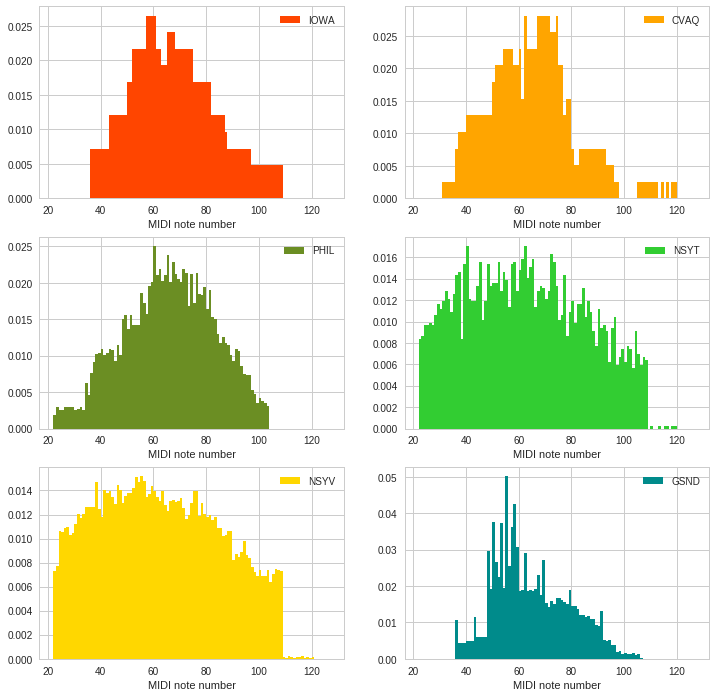

In [2]:
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    if durations:
        durations = np.array(durations)
        row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
        row.append('%.2fs' % durations.mean())
        row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    table_rows.append(row)

print(title('Basic statistics per dataset'))
print_table(table_header, table_rows, highlight_max=False)

# Pitch histograms
fig1, axs = plt.subplots(3, 2, figsize=(12, 12))
for count, dataset in enumerate(datasets):
    notes = dataset.get_data('annotations.midi_note')
    min_p = 22
    max_p = 127
    ax = axs[count//2,count%2]
    ax.hist(notes, bins=max_p-min_p, range=(min_p,max_p), normed=True, label=dataset.short_name, color=COLORS[count])
    ax.set_xlabel('MIDI note number')
    ax.legend()
plt.show()



General pitch estimation results (IOWA)
****************************************


Method          Exact   PitchClass   
-------------------------------------
ACExtractorV1   70.60   73.25        
ACExtractorV2   70.36   73.01        
QMULPYin        64.58   68.43        
ESSPYin         64.34   67.95        


General pitch estimation results (CVAQ)
****************************************


Method          Exact   PitchClass   
-------------------------------------
QMULPYin        41.69   63.94        
ACExtractorV1   34.53   53.45        
ACExtractorV2   34.53   53.45        
ESSPYin         27.37   41.43        


General pitch estimation results (PHIL)
****************************************


Method          Exact   PitchClass   
-------------------------------------
QMULPYin        52.73   55.62        
ACExtractorV1   51.17   53.66        
ACExtractorV2   51.06   53.57        
ESSPYin         46.12   48.90        


General pitch estimation results (NSYT)
*******************

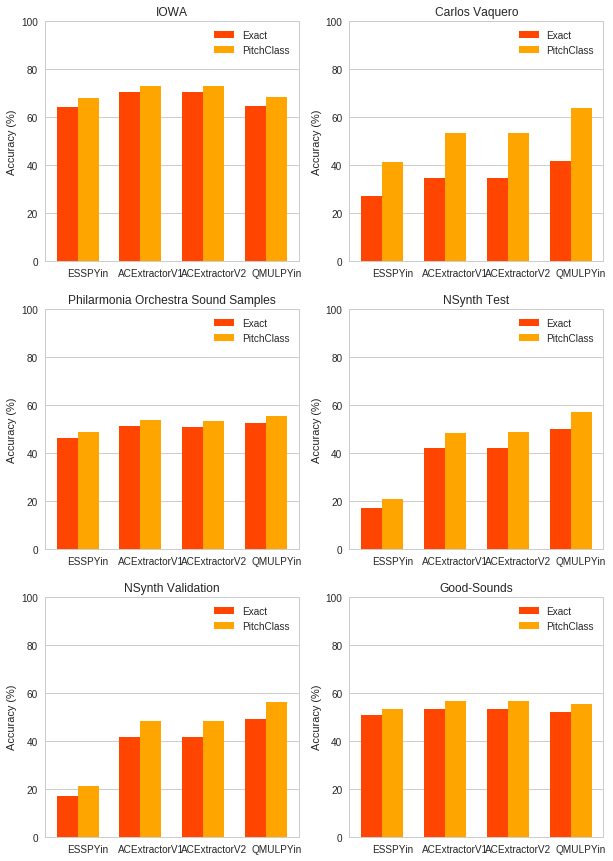

In [3]:
all_datasets_method_results = dict()
all_datasets_method_results_stats = defaultdict(list)
fig1, axs = plt.subplots(3, 2, figsize=(10, 15))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral pitch estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = defaultdict(list)
            all_datasets_method_results_stats[method] = defaultdict(list)
        try:
            table_row = [DISPLAY_NAMES.get(method, method)]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                acc_method_avg = 100 * basic_statistics(method_results)['avg']
                table_row.append(acc_method_avg)
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
                all_datasets_method_results_stats[method][accuracy_func.__name__].append(acc_method_avg)
            table_rows.append(table_row)
        except IndexError:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    ax = axs[count//2,count%2]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method) for method in methods_to_compare], rotation=0)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [4]:
print(title("General pitch estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names + ['Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results_stats.items():
    table_row = [DISPLAY_NAMES.get(method, method)]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)


General pitch estimation results (ALL DATASETS)
-----------------------------------------------

Method          Exact   PitchClass   Mean accuracy   
-----------------------------------------------------
QMULPYin        51.72   59.50        55.61           
ACExtractorV2   48.82   55.59        52.20           
ACExtractorV1   48.85   55.56        52.20           
ESSPYin         37.10   42.29        39.69           


In [5]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print("")
    print(title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy_functions:
        print('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [DISPLAY_NAMES.get(method, method) for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([DISPLAY_NAMES.get(method_a, method_a)] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset IOWA
----------------------------------


Measure: exact_match
                ESSPYin     ACExtractorV1   ACExtractorV2   QMULPYin   
-----------------------------------------------------------------------
ESSPYin         -           0.000308*       0.000464*       1          
ACExtractorV1   0.000308*   -               1               0.00497*   
ACExtractorV2   0.000464*   1               -               0.00672*   
QMULPYin        1           0.00497*        0.00672*        -          

Measure: pitch_class
                ESSPYin    ACExtractorV1   ACExtractorV2   QMULPYin   
----------------------------------------------------------------------
ESSPYin         -          0.00765*        0.0104          0.897      
ACExtractorV1   0.00765*   -               1               0.0293     
ACExtractorV2   0.0104     1               -               0.0377     
QMULPYin        0.897      0.0293          0.0377          -          


Statistical tests for d

/opt/conda/lib/python3.6/site-packages/statsmodels/sandbox/stats/runs.py:559: RuntimeWarning: divide by zero encountered in true_divide
  stat = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


                ESSPYin     ACExtractorV1   ACExtractorV2   QMULPYin    
------------------------------------------------------------------------
ESSPYin         -           5.89e-19*       3.89e-18*       1.04e-27*   
ACExtractorV1   5.89e-19*   -               0.44            0.00768*    
ACExtractorV2   3.89e-18*   0.44            -               0.0041*     
QMULPYin        1.04e-27*   0.00768*        0.0041*         -           

Measure: pitch_class
                ESSPYin     ACExtractorV1   ACExtractorV2   QMULPYin    
------------------------------------------------------------------------
ESSPYin         -           1.13e-16*       4.14e-16*       9.02e-30*   
ACExtractorV1   1.13e-16*   -               0.596           0.000572*   
ACExtractorV2   4.14e-16*   0.596           -               0.00029*    
QMULPYin        9.02e-30*   0.000572*       0.00029*        -           


Statistical tests for dataset NSYT
----------------------------------


Measure: exact_match
       

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning

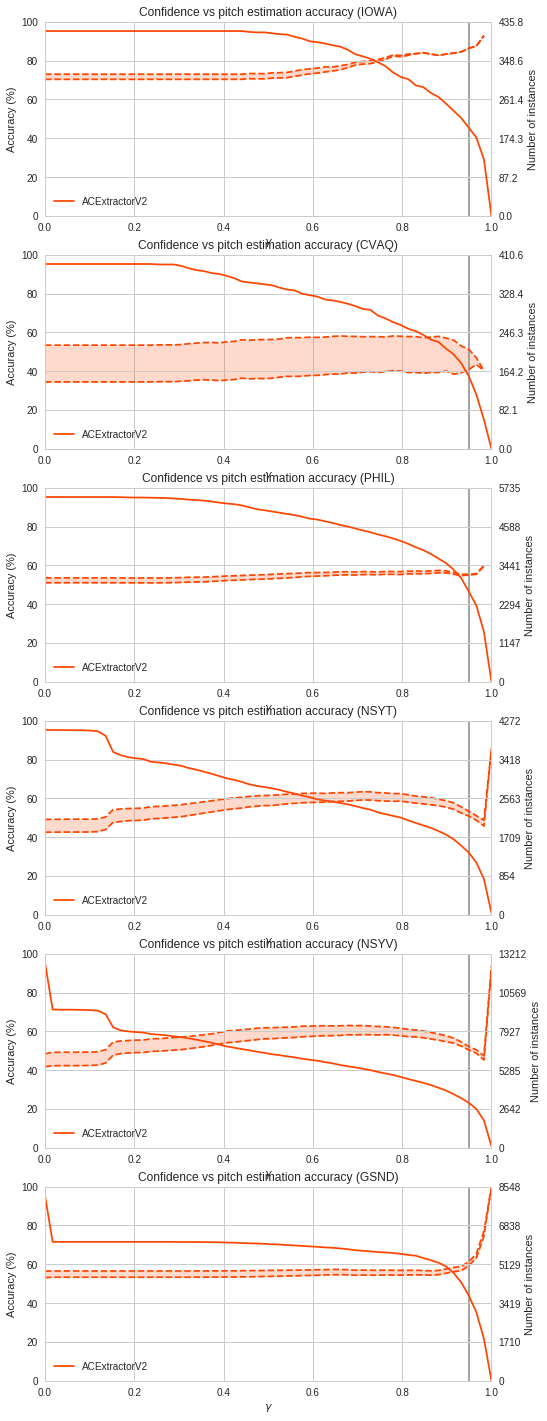

In [9]:
# Accuracy vs confidence per dataset

fig1, axs = plt.subplots(6, 1, figsize=(8, 25))
for count, dataset in enumerate(datasets):
    ax1 = axs[count]#//2,count%2]
    ax2 = ax1.twinx()
    for count, method in enumerate(['ACExtractorV2']):
        exact = list()
        pclass = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                #print(max(dataset.get_data('analysis.ACExtractorV2.note_confidence')))
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'note_confidence'), conf_min)]).data
                #print(len(filtered_data))
                exact.append(100 * basic_statistics(exact_match(filtered_data, method))['avg'])
                pclass.append(100 * basic_statistics(pitch_class(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, exact, color=COLORS[count], ls="--")
        ax1.plot(steps, pclass, color=COLORS[count], ls="--")
        ax1.fill_between(steps, exact, pclass, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    ax1.set_xlim(0.0, 1.0)
    ax1.set_title('Confidence vs pitch estimation accuracy (%s)' % dataset.short_name)


In [11]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in ['ACExtractorV2']:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'note_confidence'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(exact_match(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(pitch_class(filtered_data, method))['avg']
        except IndexError:
            print('Unable to compute results for method %s and dataset %s' % (method, dataset.short_name))
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
        
        print(dataset.short_name)
        print('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)

print_table(table_header, table_rows)

IOWA
A=86.36 - 86.36%, N=48%
CVAQ
A=40.52 - 50.98%, N=39%
PHIL
A=55.03 - 55.44%, N=49%
NSYT
A=50.66 - 53.16%, N=33%
NSYV
A=50.26 - 52.04%, N=24%
GSND
A=59.52 - 61.59%, N=46%
Method          IOWA                      CVAQ                      PHIL                      NSYT                      NSYV                      GSND                      
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ACExtractorV2   A=86.36 - 86.36%, N=48%   A=40.52 - 50.98%, N=39%   A=55.03 - 55.44%, N=49%   A=50.66 - 53.16%, N=33%   A=50.26 - 52.04%, N=24%   A=59.52 - 61.59%, N=46%   
